<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C2/C2.html"><img src="../data/C2_nav.png" width="100"  style="float:right;" alt="C2"></a>
<h1>STFT: Frequency Interpolation</h1> 
</div>

<br/>

<p>
In the <a href="../C2/C2_STFT-FreqGridDensity.html">FMP notebook on Frequency Grid Density</a>, we showed how to increase the density by suitably padding the windowed sections in the STFT computation. As an alternative, we discuss in this notebook interpolation techniques along the frequency direction to adjust the frequency resolution.
</p> 

## Interpolation

Given a sequence of data points, the goal of **interpolation** is to compute intermediate data points that refine the sequence in some meaningful way. To be more concrete, let us consider a function $f\colon\mathbb{R}\to\mathbb{R}$ that maps a parameter $t\in\mathbb{R}$ to a value $f(t)\in\mathbb{R}$. Suppose that we have values $f(t_n)$ only for a discrete set of parameters $t_n\in\mathbb{R}$ for $n\in\mathbb{Z}$, where we assuming $t_{n} > t_{n-1}$. Then, the goal of interpolation is to estimate values $f^\ast(t)$ from the known values $f(t_n)$ such that 

$$
f^\ast(t) \approx f(t)
$$

for any $t\in\mathbb{R}$. In practice, the function $f$ is not known. However, one often assumes certain properties of $f$ such as continuity, smoothness, differentiability, and so on. 

The simplest interpolation method is known as **piecewise constant interpolation** (or **nearest-neighbor interpolation**). Given a parameter $t\in\mathbb{R}$, one simply takes the nearest parameter $t_n$ and defines 

$$f^\ast(t)=f(t_n).$$

In the following example, we compute a nearest-neighbor interpolation using the Python class [`scipy.inperploate.interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html). 

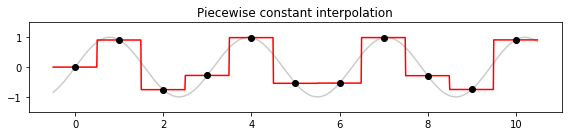

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import librosa
%matplotlib inline

# Simulates the original function
t = np.arange(-0.5, 10.5, 0.01)
f = np.sin(2 * t)

# Known funcion values
t_n = np.arange(0, 11)
f_n = np.sin(2 * t_n)

# Interpolation
f_interpol_nearest = interp1d(t_n, f_n, kind='nearest', fill_value='extrapolate')(t)

plt.figure(figsize=(8, 2)) 
plt.plot(t, f, color=(0.8, 0.8, 0.8))
plt.plot(t, f_interpol_nearest, 'r-')
plt.plot(t_n, f_n, 'ko')
plt.ylim([-1.5,1.5])
plt.title('Piecewise constant interpolation')
plt.tight_layout()

Nearest-neighbor interpolation typically yields a discontinuous function. To obtain a continuous interpolation function, a simple alternative is **linear interpolation**. Given some parameter $t$ that lies between $t_{n-1}$ and $t_n$, one defines

$$
f^\ast(t)=f(t_{n-1}) + (f(t_{n})-f(t_{n-1}))\cdot\frac{t-t_{n-1}}{t_{n} - t_{n-1}}. 
$$

Continuing our example above, we obtain the following result:

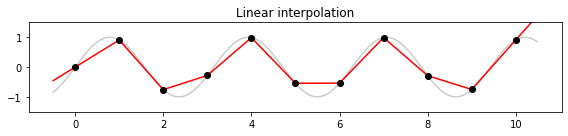

In [2]:
f_interpol_linear = interp1d(t_n, f_n, kind='linear', fill_value='extrapolate')(t)

plt.figure(figsize=(8, 2)) 
plt.plot(t, f, color=(0.8, 0.8, 0.8))
plt.plot(t, f_interpol_linear, 'r-')
plt.plot(t_n, f_n, 'ko')
plt.ylim([-1.5,1.5])
plt.title('Linear interpolation')
plt.tight_layout()

The Python class [`scipy.inperploate.interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) offer several kinds of interpolation methods including nearest-neighbor, linear, and spline interpolations of various orders. As another example, we show the result for **cubic interpolation** (spline of third order) and refer to the [Python documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) for further details.

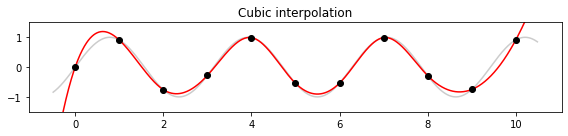

In [3]:
f_interpol_cubic = interp1d(t_n, f_n, kind='cubic', fill_value='extrapolate')(t)

plt.figure(figsize=(8, 2)) 
plt.plot(t, f, color=(0.8, 0.8, 0.8))
plt.plot(t, f_interpol_cubic, 'r-')
plt.plot(t_n, f_n, 'ko')
plt.ylim([-1.5,1.5])
plt.title('Cubic interpolation')
plt.tight_layout()

## Frequency Interpolation

To increase the density of the linear **frequency grid** introduced by the DFT, one may use a [larger DFT based on zero-padding](../C2/C2_STFT-FreqGridDensity.html). We now introduce an alternative by applying interpolation techniques in the frequency domain. Following Section 2.1.3 of  <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, let $x\in \mathbb{R}^N$ be a discrete signal of length $N\in\mathbb{N}$, $F_\mathrm{s}$ the sampling rate, $X = \mathrm{DFT}_N \cdot x$ the DFT, and $Y=|X|$ the magnitude DFT. Then the index $k$ of $Y(k)$ corresponds to the physical frequency

\begin{equation}
         F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{N}
\end{equation}

given in Hertz.  In other words, the resulting frequency grid has a resolution of $F_\mathrm{s}/N$. Introducing a factor $\rho\in\mathbb{N}$, we refine the frequency grid considering the resolution $F_\mathrm{s}/(\rho\cdot N)$. Based on this refined frequency grid, we compute magnitude frequency coefficients using interpolation techniques. This strategy is implemented in the following code example.

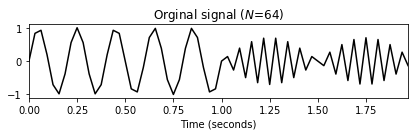

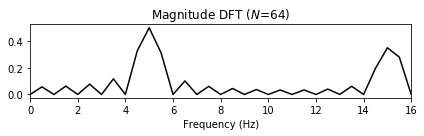

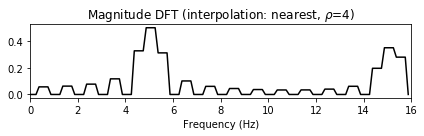

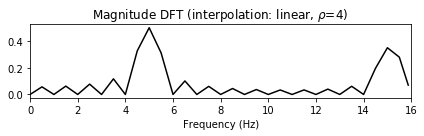

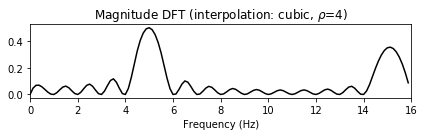

In [4]:
Fs = 32
duration = 2
omega1 = 5
omega2 = 15
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))

plt.figure(figsize=(6, 2))
plt.plot(t, x, c='k')
plt.title('Orginal signal ($N$=%d)' % N)
plt.xlabel('Time (seconds)')
plt.xlim([t[0], t[-1]])   
plt.tight_layout()

Y = np.abs(np.fft.fft(x)) / Fs
Y = Y[:N//2+1]
F_coef = np.arange(N//2+1)*Fs/N
plt.figure(figsize=(6, 2))
plt.plot(F_coef,Y, c='k')
plt.title('Magnitude DFT ($N$=%d)' % N)
plt.xlabel('Frequency (Hz)')
plt.xlim([F_coef[0], F_coef[-1]])     
plt.tight_layout()

def interpolate_plot_DFT(N, Fs, F_coef, rho, int_method):
    F_coef_interpol = np.arange(F_coef[0], F_coef[-1], Fs/(rho*N))
    Y_interpol = interp1d(F_coef, Y, kind=int_method)(F_coef_interpol)
    plt.figure(figsize=(6, 2))
    plt.plot(F_coef_interpol, Y_interpol, c='k')
    plt.title(r'Magnitude DFT (interpolation: %s, $\rho$=%d)'%(int_method,rho))
    plt.xlabel('Frequency (Hz)')
    plt.xlim([F_coef[0], F_coef[-1]])
    plt.tight_layout()

rho = 4
interpolate_plot_DFT(N=N, Fs=Fs, F_coef=F_coef, rho=rho, int_method='nearest')
interpolate_plot_DFT(N=N, Fs=Fs, F_coef=F_coef, rho=rho, int_method='linear')
interpolate_plot_DFT(N=N, Fs=Fs, F_coef=F_coef, rho=rho, int_method='cubic')

## Frequency Interpolation for STFT

To refine the frequency grid of an STFT, one can apply the interpolation strategy along the frequency direction. In the next example, we use the note C4 played by a violin (with vibrato).

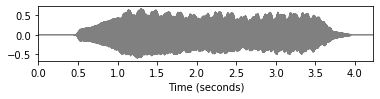

In [5]:
import os
import IPython.display as ipd

# Load wav
fn_wav = os.path.join('..', 'data', 'C2', 'FMP_C2_F05c_C4_violin.wav')

Fs = 11025
x, Fs = librosa.load(fn_wav, sr=Fs)
ipd.display(ipd.Audio(x, rate=Fs))

t_wav = np.arange(0, x.shape[0]) * 1 / Fs
plt.figure(figsize=(6, 1))
plt.plot(t_wav, x, c='gray')
plt.xlim([t_wav[0], t_wav[-1]])
plt.xlabel('Time (seconds)');

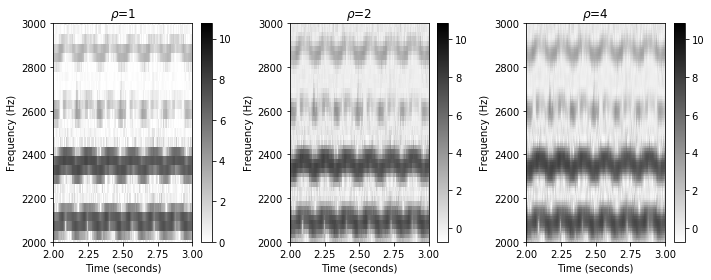

In [6]:
def stft_conventionFMP(x, Fs, N, H, pad_mode='constant', center=True, mag=False, gamma=0):  
    """Compute the discrete short-time Fourier transform (STFT)

    Notebook: C2/C2_STFT-FreqGridInterpol.ipynb

    Args:
        x: Signal to be transformed
        Fs: Sampling rate
        N: Window size
        H: Hopsize
        pad_mode: Padding strategy is used in librosa
        center: Centric view as used in librosa
        mag: Computes magnitude STFT if mag==True
        gamma: Constant for logarithmic compression (only applied when mag==True)

    Returns:
        X: Discrete (magnitude) short-time Fourier transform
    """
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N,
                     window='hann', pad_mode=pad_mode, center=center)
    if mag==True:
        X = np.abs(X)**2
        if gamma>0:
            X = np.log(1 + gamma * X)
    F_coef = librosa.fft_frequencies(sr=Fs, n_fft=N)
    T_coef = librosa.frames_to_time(np.arange(X.shape[1]), sr=Fs, hop_length=H) 
    # T_coef = np.arange(X.shape[1]) * H/Fs
    # F_coef = np.arange(N//2+1) * Fs/N
    return X, T_coef, F_coef

def compute_F_coef_linear(N, Fs, rho=1):
    """Refines the frequency vector by factor of rho

    Notebook: C2/C2_STFT-FreqGridInterpol.ipynb

    Args:
        N: Window size
        Fs: Sampling rate
        rho: Factor for refinement

    Returns:
        F_coef_linear: Refined frequency vector
    """    
    L = rho * N
    F_coef_new = np.arange(0, L//2+1) * Fs / L  
    return F_coef_new

def interpolate_freq_stft(Y, F_coef, F_coef_new):
    """Interpolation of STFT along frequency axis

    Notebook: C2/C2_STFT-FreqGridInterpol.ipynb

    Args:
        Y: Magnitude STFT
        F_coef: Vector of frequency values
        F_coef_new: Vector of new frequency values

    Returns:
        Y_interpol: Interploated magnitude STFT
    """       
    compute_Y_interpol = interp1d(F_coef, Y, kind='cubic', axis=0)
    Y_interpol = compute_Y_interpol(F_coef_new)
    return Y_interpol

def plot_compute_spectrogram_physical(x, Fs, N, H, xlim, ylim, rho=1, color='gray_r'):
    Y, T_coef, F_coef = stft_conventionFMP(x, Fs, N, H, mag=True, gamma=100)
    F_coef_new = compute_F_coef_linear(N, Fs, rho=rho)
    Y_interpol = interpolate_freq_stft(Y, F_coef, F_coef_new)    
    extent=[T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
    plt.imshow(Y_interpol, cmap=color , aspect='auto', origin='lower', extent=extent)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.title(r'$\rho$=%d' % rho)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.colorbar()

xlim_sec = [2, 3]
ylim_hz = [2000, 3000]

N = 256
H = 64
plt.figure(figsize=(10, 4))
 
plt.subplot(1, 3, 1)
plot_compute_spectrogram_physical(x, Fs, N, H, xlim=xlim_sec, ylim=ylim_hz, rho=1)

plt.subplot(1, 3, 2)
plot_compute_spectrogram_physical(x, Fs, N, H, xlim=xlim_sec, ylim=ylim_hz, rho=2)

plt.subplot(1, 3, 3)
plot_compute_spectrogram_physical(x, Fs, N, H, xlim=xlim_sec, ylim=ylim_hz, rho=4)

plt.tight_layout()

## Log-Frequency STFT via Interpolation

This interpolation techniques can be also used for a non-linear deformation of the frequency grid. For example, one may convert the linearly spaced spaced frequency axis (measured in Hertz) into a logarithmically spaced frequency axis (measured in pitches or cents). This results in a [**log-frequency spectrogram**](../C3/C3S1_SpecLogFreq-Chromagram.html), a concept introduced in Section 3.1.1 of  <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. Without explaining the details, the following code shows how one may implement a logarithmic conversion of the frequency axis. The frequency values are then obtained via interpolation as introduced above. 

The main step is to define a logarithmically spaced frequency grid. In the following we use the notion of **cents**, which is a logarithmic unit of measure used for musical intervals (see Section 1.3.2 of  <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. Given a reference frequency $\omega_0$, the distance between an arbitrary frequency $\omega$ and $\omega_0$ is then specified as 

$$
     \log_2\left(\frac{\omega}{\omega_0}\right)\cdot 1200
$$

given in cents. In the following function, we compute a logarithmically spaced frequency axis starting with a minimal frequency value (the parameter `F_min` is used as reference frequency $\omega_0$, thus corresponding to $0$ cents). Furthermore, the function has a parameter `R` which specifies the logarithmic resolution in cents. In other words, two subsequent frequency bins on the logarithmic frequency axis are `R` cents apart. The maximum frequency to be considered is specified by another parameter `F_max`. In the following example, we use the frequencies `F_min = 100` (corresponding to $0$ cents) and `F_max = 3200` (corresponding to $6000$ cents). Furthermore, the resolution is set to `R=20` (corresponding to $60$ frequency bins per octave).

In [7]:
def compute_F_coef_log(R, F_min, F_max):
    """Adapts the frequency vector in a logarithmic fashion

    Notebook: C2/C2_STFT-FreqGridInterpol.ipynb

    Args:
        R: Resolution (cents)
        F_min: minimum frequency
        F_max: maximum frequency (not included)

    Returns:
        F_coef_log: Refined frequency vector with values given in Hz)
        F_coef_cents: Refined frequency vector with values given in cents
                      Note: F_min serves as reference (0 cents)
    """     
    n_bins = np.ceil(1200 * np.log2(F_max / F_min) / R).astype(int)
    F_coef_log = 2 ** (np.arange(0, n_bins) * R / 1200) * F_min 
    F_coef_cents = 1200 * np.log2(F_coef_log / F_min)
    return F_coef_log, F_coef_cents 

N = 1024
H = 256
Y, T_coef, F_coef = stft_conventionFMP(x, Fs, N, H, mag=True, gamma=100)

F_min = 100
F_max = 3200
R = 20
F_coef_log, F_coef_cents = compute_F_coef_log(R, F_min, F_max)

print('#bins=%3d, F_coef[0]      =%6.2f, F_coef[1]      =%6.2f, F_coef[-1]      =%6.2f'%(len(F_coef),F_coef[0], F_coef[1], F_coef[-1]))
print('#bins=%3d, F_coef_log[0]  =%6.2f, F_coef_log[1]  =%6.2f, F_coef_log[-1]  =%6.2f'%(len(F_coef_log),F_coef_log[0], F_coef_log[1], F_coef_log[-1]))
print('#bins=%3d, F_coef_cents[0]=%6.2f, F_coef_cents[1]=%6.2f, F_coef_cents[-1]=%6.2f'%(len(F_coef_cents),F_coef_cents[0], F_coef_cents[1], F_coef_cents[-1]))

#bins=513, F_coef[0]      =  0.00, F_coef[1]      = 10.77, F_coef[-1]      =5512.50
#bins=300, F_coef_log[0]  =100.00, F_coef_log[1]  =101.16, F_coef_log[-1]  =3163.24
#bins=300, F_coef_cents[0]=  0.00, F_coef_cents[1]= 20.00, F_coef_cents[-1]=5980.00


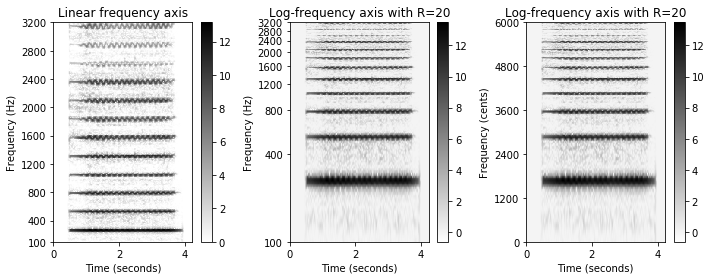

In [8]:
Y_interpol = interpolate_freq_stft(Y, F_coef, F_coef_log)
color = 'gray_r' 

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
extent=[T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
plt.imshow(Y, cmap=color , aspect='auto', origin='lower', extent=extent)
y_ticks_freq = np.array([100, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200])
plt.yticks(y_ticks_freq)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Linear frequency axis')
plt.ylim([F_min, F_max])
plt.colorbar()

plt.subplot(1, 3, 2)
extent=[T_coef[0], T_coef[-1], F_coef_cents[0], F_coef_cents[-1]]
plt.imshow(Y_interpol, cmap=color , aspect='auto', origin='lower', extent=extent)
y_tick_freq_cents = 1200 * np.log2(y_ticks_freq / F_min)
plt.yticks(y_tick_freq_cents, y_ticks_freq)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Log-frequency axis')
plt.title('Log-frequency axis with R=%d' % R)
plt.colorbar()

plt.subplot(1, 3, 3)
extent=[T_coef[0], T_coef[-1], F_coef_cents[0], F_coef_cents[-1]]
plt.imshow(Y_interpol, cmap=color , aspect='auto', origin='lower', extent=extent)
y_ticks_cents = np.array([0, 1200, 2400, 3600, 4800, 6000])
plt.yticks(y_ticks_cents)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (cents)')
plt.title('Log-frequency axis')
plt.title('Log-frequency axis with R=%d' % R)
plt.colorbar()
plt.tight_layout()

## Further Notes

* The function `stft_conventionFMP` implements the STFT variant as used for most parts in the FMP notebooks, see also the <a href="../C2/C2_STFT-Conventions.html">FMP notebook on STFT conventions and implementations</a>.
* The transformation of the STFT frequency axis is a crucial step in many music processing applications. For example, in the <a href="../C3/C3S1_SpecLogFreq-Chromagram.html">FMP notebook on log-frequency spectrograms and chromagrams</a>, the frequency axis is partitioned logarithmically to yield a musically motivated pitch axis. 
* Similarly, in the <a href="../C8/C8S2_SalienceRepresentation.html">FMP notebook on salience representations</a>, the frequency axis is converted in a logarithmic fashion.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/rosenzweig">Sebastian Rosenzweig</a>.
</div>   

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>